# Experiments with real data (German Credit)

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

## Requirements

In [1]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_german_credit_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_german_credit import get_config as get_config_exp_1_german_credit
from config_experiment_3_german_credit import get_config as get_config_exp_3_german_credit
from config_experiment_4_german_credit import get_config as get_config_exp_4_german_credit

## Data exploration


### Conceptual description

| Variable              | Descripción                                    | Tipo                  | Valores                                                                 |
| --------------------- | ---------------------------------------------- | --------------------- | ----------------------------------------------------------------------- |
| credit-risk           | Etiqueta binaria del comportamiento crediticio | Binaria               | `good (1)`, `bad (0)`                                                   |
| checking_status       | Estado de la cuenta corriente del solicitante  | Categórica ordinal    | `no checking (0)`, `<0 (1)`, `0<=X<200 (2)`, `>=200 (3)`                |
| duration              | Duración del crédito en meses                  | Numérica (discreta)   | 6, 12, 24, 48, 60, ...                                                  |
| credit_history        | Historial crediticio previo del solicitante    | Categórica nominal    | `all paid (0)`, `critical/other existing credit (1)`, `delayed previously (2)`, `existing paid (3)`, `no credits/all paid (4)` |
| purpose               | Finalidad declarada del crédito                | Categórica nominal    | `business (0)`, `domestic appliance (1)`, `education (2)`, `furniture/equipment (3)`, `new car (4)`, `other (5)`, `radio/tv (6)`, `repairs (7)`, `retraining (8)`, `used car (9)` |
| credit_amount         | Monto del crédito solicitado                   | Numérica (continua)   | 250 – 18424 (ej.: 1169, 5951, 9055, ...)                                |
| savings_status        | Nivel de ahorro declarado                      | Categórica ordinal    | `no known savings (0)`, `<100 (1)`, `100<=X<500 (2)`, `500<=X<1000 (3)`, `>=1000 (4)` |
| employment            | Tiempo en el empleo actual                     | Categórica ordinal    | `unemployed (0)`, `<1 (1)`, `1<=X<4 (2)`, `4<=X<7 (3)`, `>=7 (4)`       |
| installment_commitment| Porcentaje del ingreso asignado a la cuota mensual | Categórica ordinal | 1, 2, 3, 4                                                              |
| other_parties         | Existencia de co-solicitante o avalista        | Categórica nominal    | `co applicant (0)`, `guarantor (1)`, `none (2)`                         |
| residence_since       | Años de residencia en el domicilio actual      | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| property_magnitude    | Tipo de propiedad o garantía declarada         | Categórica nominal    | `car (0)`, `life insurance (1)`, `no known property (2)`, `real estate (3)` |
| age                   | Edad del solicitante                           | Numérica (continua)   | 19 – 75 (ej.: 22, 45, 53, ...)                                          |
| other_payment_plans   | Otros planes de pago disponibles               | Categórica nominal    | `bank (0)`, `none (1)`, `stores (2)`                                    |
| housing               | Régimen de vivienda                            | Categórica nominal    | `for free (0)`, `own (1)`, `rent (2)`                                   |
| existing_credits      | Número de créditos vigentes                    | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| job                   | Tipo de ocupación                              | Categórica nominal    | `high qualif/self emp/mgmt (0)`, `skilled (1)`, `unemp/unskilled non res (2)`, `unskilled resident (3)` |
| num_dependents        | Número de personas dependientes                | Numérica (discreta)   | 1, 2                                                                    |
| own_telephone         | Si el solicitante tiene teléfono               | Binaria               | `none (0)`, `yes (1)`                                                   |
| foreign_worker        | Si el solicitante es trabajador extranjero     | Binaria               | `no (0)`, `yes (1)`                                                     |
| sex                   | Género del solicitante                         | Categórica nominal    | `female (0)`, `male (1)`                                                |
| marital_status        | Estado civil del solicitante                   | Categórica nominal    | `div/dep/mar (0)`, `div/sep (1)`, `mar/wid (2)`, `single (3)`           |


### Data reading

In [2]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [3]:
X.head()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status,savings_status,employment,own_telephone,foreign_worker,sex,credit_history,purpose,other_parties,property_magnitude,other_payment_plans,housing,job,marital_status
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
6,1169,4,4,67,2,1,1,0,4,1,1,1,1,6,2,3,1,1,1,3
48,5951,2,2,22,1,1,2,1,2,0,1,0,3,6,2,3,1,1,1,0
12,2096,2,3,49,1,2,0,1,3,0,1,1,1,2,2,3,1,1,3,3
42,7882,2,4,45,1,2,1,1,3,0,1,1,3,3,1,1,1,0,1,3
24,4870,3,4,53,2,2,1,1,2,0,1,1,2,4,2,2,1,0,1,3


In [4]:
y.head(5)

credit-risk
i64
1
0
1
1
0


In [5]:
n_clusters

2

In [6]:
print(p1, p2, p3)

10 3 8


In [7]:
encoding

{'credit-risk': {'bad': 0, 'good': 1},
 'own_telephone': {'none': 0, 'yes': 1},
 'foreign_worker': {'no': 0, 'yes': 1},
 'sex': {'female': 0, 'male': 1},
 'credit_history': {'all paid': 0,
  'critical/other existing credit': 1,
  'delayed previously': 2,
  'existing paid': 3,
  'no credits/all paid': 4},
 'purpose': {'business': 0,
  'domestic appliance': 1,
  'education': 2,
  'furniture/equipment': 3,
  'new car': 4,
  'other': 5,
  'radio/tv': 6,
  'repairs': 7,
  'retraining': 8,
  'used car': 9},
 'other_parties': {'co applicant': 0, 'guarantor': 1, 'none': 2},
 'property_magnitude': {'car': 0,
  'life insurance': 1,
  'no known property': 2,
  'real estate': 3},
 'other_payment_plans': {'bank': 0, 'none': 1, 'stores': 2},
 'housing': {'for free': 0, 'own': 1, 'rent': 2},
 'job': {'high qualif/self emp/mgmt': 0,
  'skilled': 1,
  'unemp/unskilled non res': 2,
  'unskilled resident': 3},
 'marital_status': {'div/dep/mar': 0, 'div/sep': 1, 'mar/wid': 2, 'single': 3},
 'checking_stat

In [43]:
quant_predictors

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents',
 'checking_status',
 'savings_status',
 'employment']

In [9]:
binary_predictors

['own_telephone', 'foreign_worker', 'sex']

In [10]:
multiclass_predictors

['credit_history',
 'purpose',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'marital_status']

### Data description

In [11]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [12]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
duration,33,0.0,20.903,12.058814,4,9.0,12.0,18.0,24.0,36.0,72,3.909195,1.092542,0.07
credit_amount,921,0.0,3271.258,2822.736876,250,932.0,1366.0,2319.5,3972.0,7174.0,18424,7.265163,1.946702,0.073
installment_commitment,4,0.0,2.973,1.118715,1,1.0,2.0,3.0,4.0,4.0,4,1.789577,-0.530551,0.0
residence_since,4,0.0,2.845,1.103718,1,1.0,2.0,3.0,4.0,4.0,4,1.619455,-0.272161,0.0
age,53,0.0,35.546,11.375469,19,23.0,27.0,33.0,42.0,52.0,75,3.586811,1.019208,0.023
existing_credits,4,0.0,1.407,0.577654,1,1.0,1.0,1.0,2.0,2.0,4,4.590434,1.270666,0.006
num_dependents,2,0.0,1.155,0.362086,1,1.0,1.0,1.0,1.0,2.0,2,4.635045,1.906579,0.155
checking_status,4,0.0,1.001,0.957034,0,0.0,0.0,1.0,2.0,2.0,3,1.994079,0.429884,0.0
savings_status,5,0.0,1.19,0.966869,0,0.0,1.0,1.0,1.0,3.0,4,4.679129,1.308375,0.397
employment,5,0.0,2.384,1.208306,0,1.0,2.0,2.0,4.0,4.0,4,2.064341,-0.117438,0.0


In [13]:
cat_summary

,n_unique,perc_nan,mode
own_telephone,2,0.0,0
foreign_worker,2,0.0,1
sex,2,0.0,1
credit_history,5,0.0,3
purpose,10,0.0,6
other_parties,3,0.0,2
property_magnitude,4,0.0,0
other_payment_plans,3,0.0,1
housing,3,0.0,1
job,4,0.0,1


In [14]:
y.describe()

statistic,value
str,f64
"""count""",1000.0
"""null_count""",0.0
"""mean""",0.7
"""std""",0.458487
"""min""",0.0
"""25%""",0.0
"""50%""",1.0
"""75%""",1.0
"""max""",1.0


In [ ]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = np.round(counts/len(y), 2)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3, 1: 0.7}


In [16]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""duration""",-6.0,42.0,70,930,0.07,0.93
"""credit_amount""",-2543.0,7881.0,73,927,0.073,0.927
"""installment_commitment""",-1.0,7.0,0,1000,0.0,1.0
"""residence_since""",-1.0,7.0,0,1000,0.0,1.0
"""age""",4.5,64.5,23,977,0.023,0.977
"""existing_credits""",-0.5,3.5,6,994,0.006,0.994
"""num_dependents""",1.0,1.0,155,845,0.155,0.845
"""checking_status""",-3.0,5.0,0,1000,0.0,1.0
"""savings_status""",1.0,1.0,397,603,0.397,0.603


In [17]:
outliers_df['prop_outliers'].mean()

0.07239999999999999

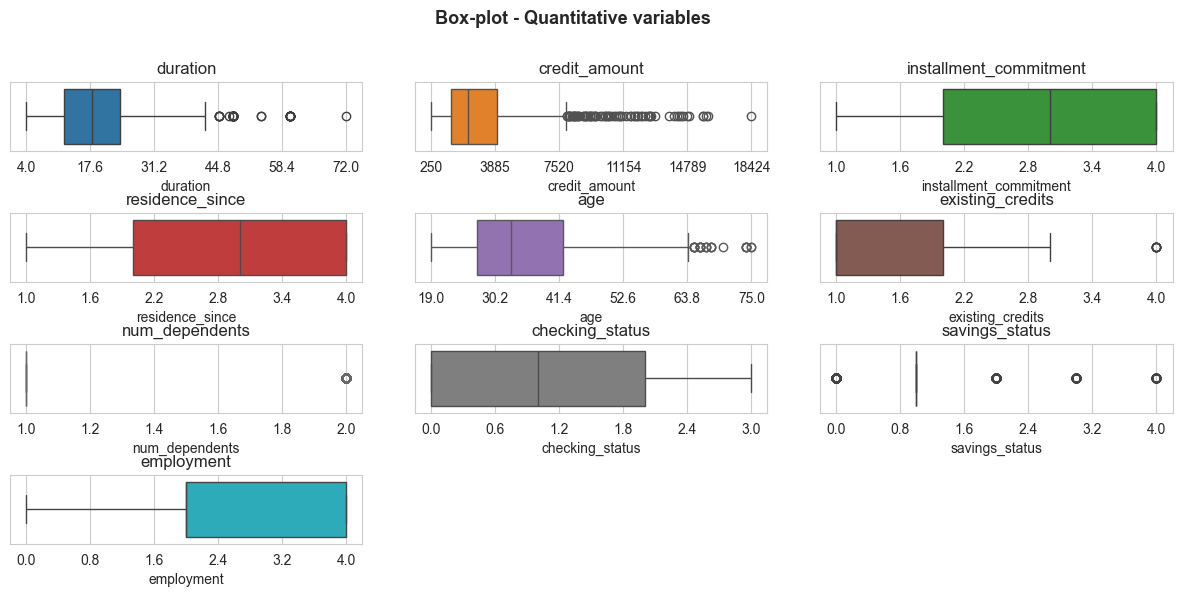

In [18]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,6), 
               quant_col_names = quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=1,
               style='whitegrid', 
               hspace=0.9, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

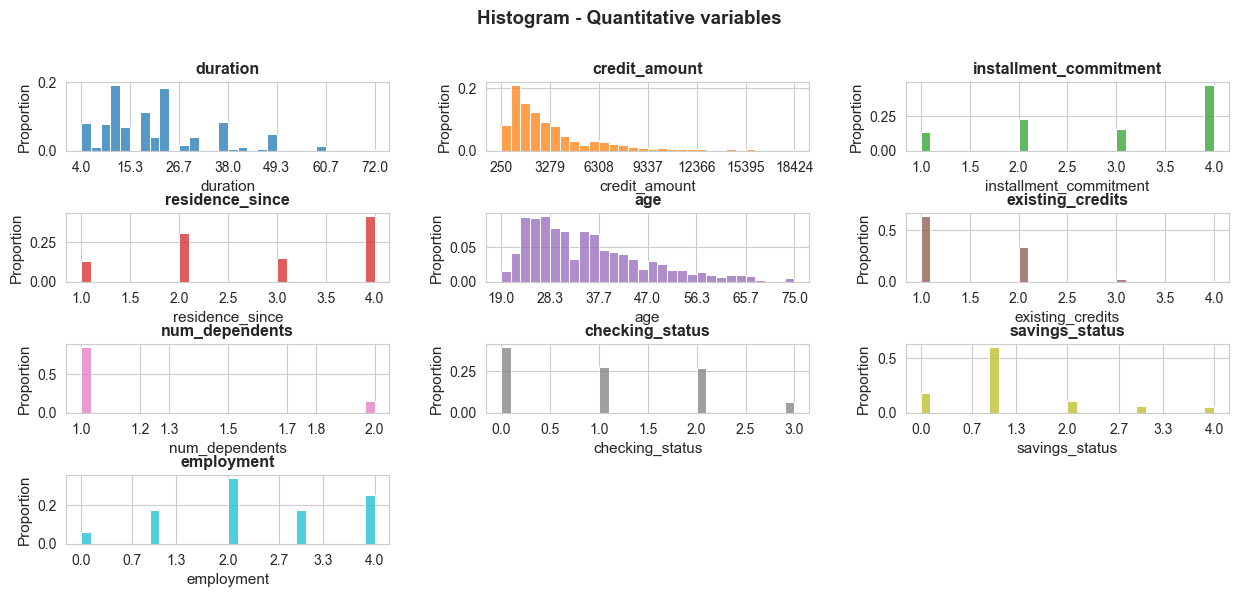

In [19]:
# Histogram
histogram_matrix(df=X, 
                 bins=30, 
                 n_cols=3, 
                 title='Histogram - Quantitative variables', 
                 figsize=(15,6), 
                 quant_col_names = quant_predictors, 
                 n_xticks=7, 
                 title_fontsize=13.5, 
                 subtitles_fontsize=11.5, 
                 save=False, 
                 file_name='', 
                 x_rotation=0, 
                 title_height=1,
                 style='whitegrid', 
                 hspace=0.9, 
                 wspace=0.3, 
                 n_round_xticks=1)

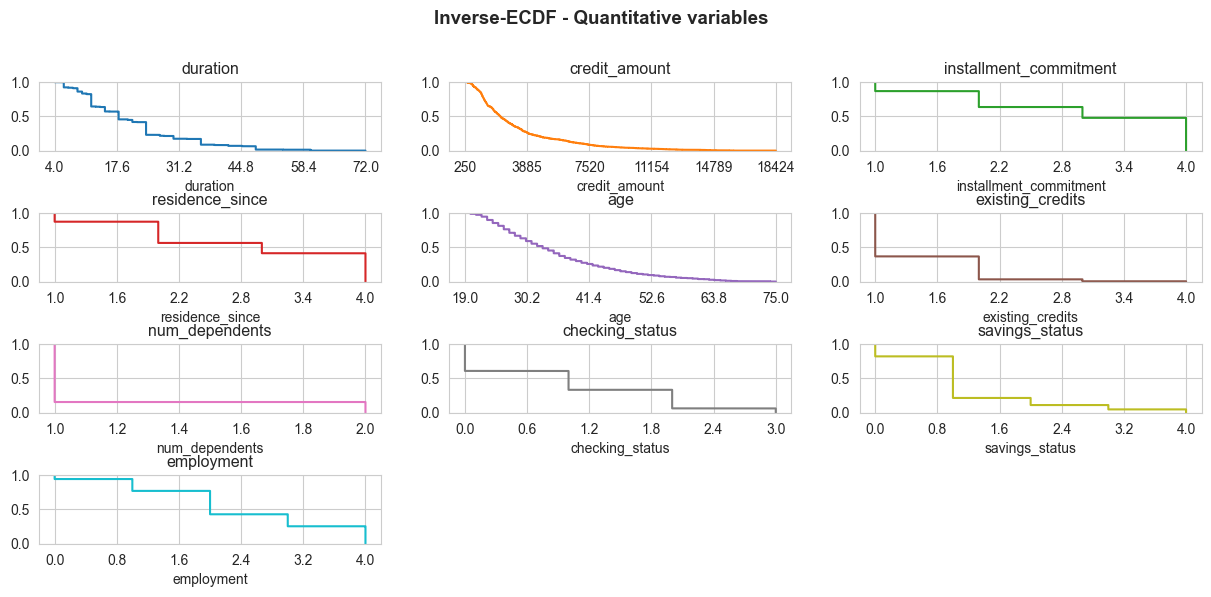

In [20]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

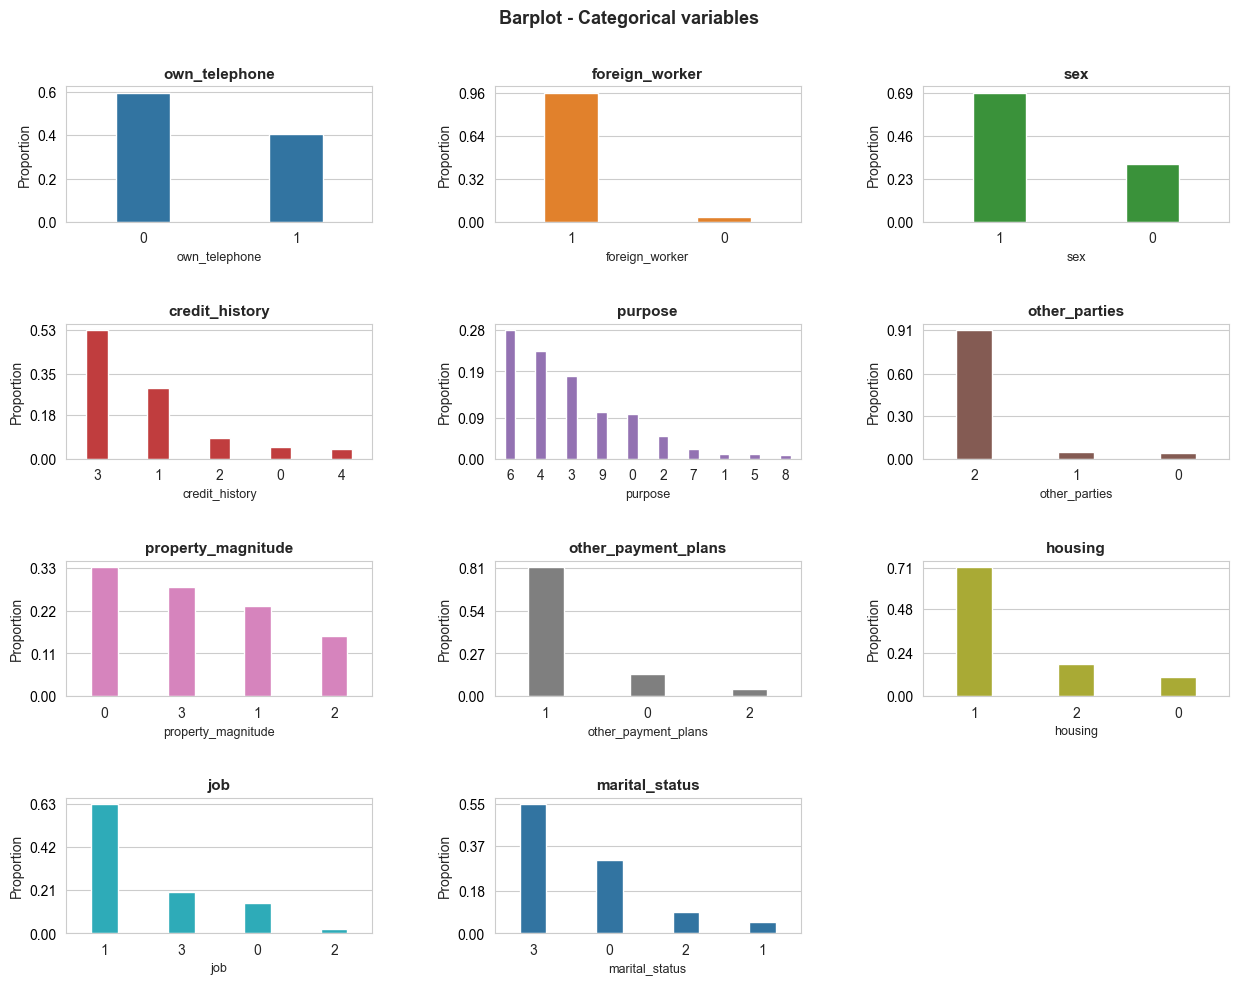

In [21]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,11), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [22]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status,savings_status,employment
duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834,0.035050,-0.064526,0.057381
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142,0.024561,-0.107538,-0.008367
installment_commitment,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207,-0.057942,-0.000805,0.126161
residence_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643,-0.059555,-0.011772,0.245081
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201,-0.049058,-0.017997,0.256227
existing_credits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667,-0.093081,-0.004176,0.125791
num_dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000,-0.040889,-0.021302,0.097192
checking_status,0.035050,0.024561,-0.057942,-0.059555,-0.049058,-0.093081,-0.040889,1.000000,-0.005614,-0.108536
savings_status,-0.064526,-0.107538,-0.000805,-0.011772,-0.017997,-0.004176,-0.021302,-0.005614,1.000000,0.014600
employment,0.057381,-0.008367,0.126161,0.245081,0.256227,0.125791,0.097192,-0.108536,0.014600,1.000000


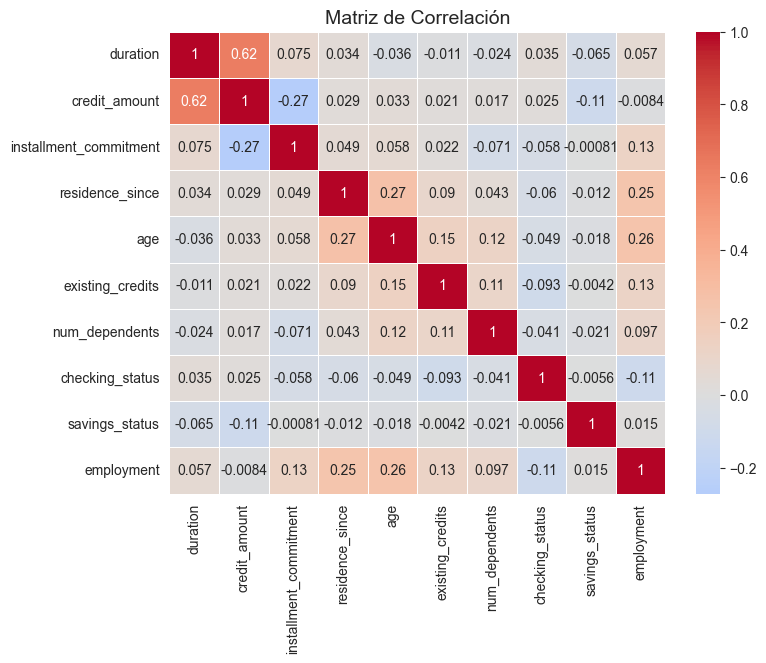

In [23]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()


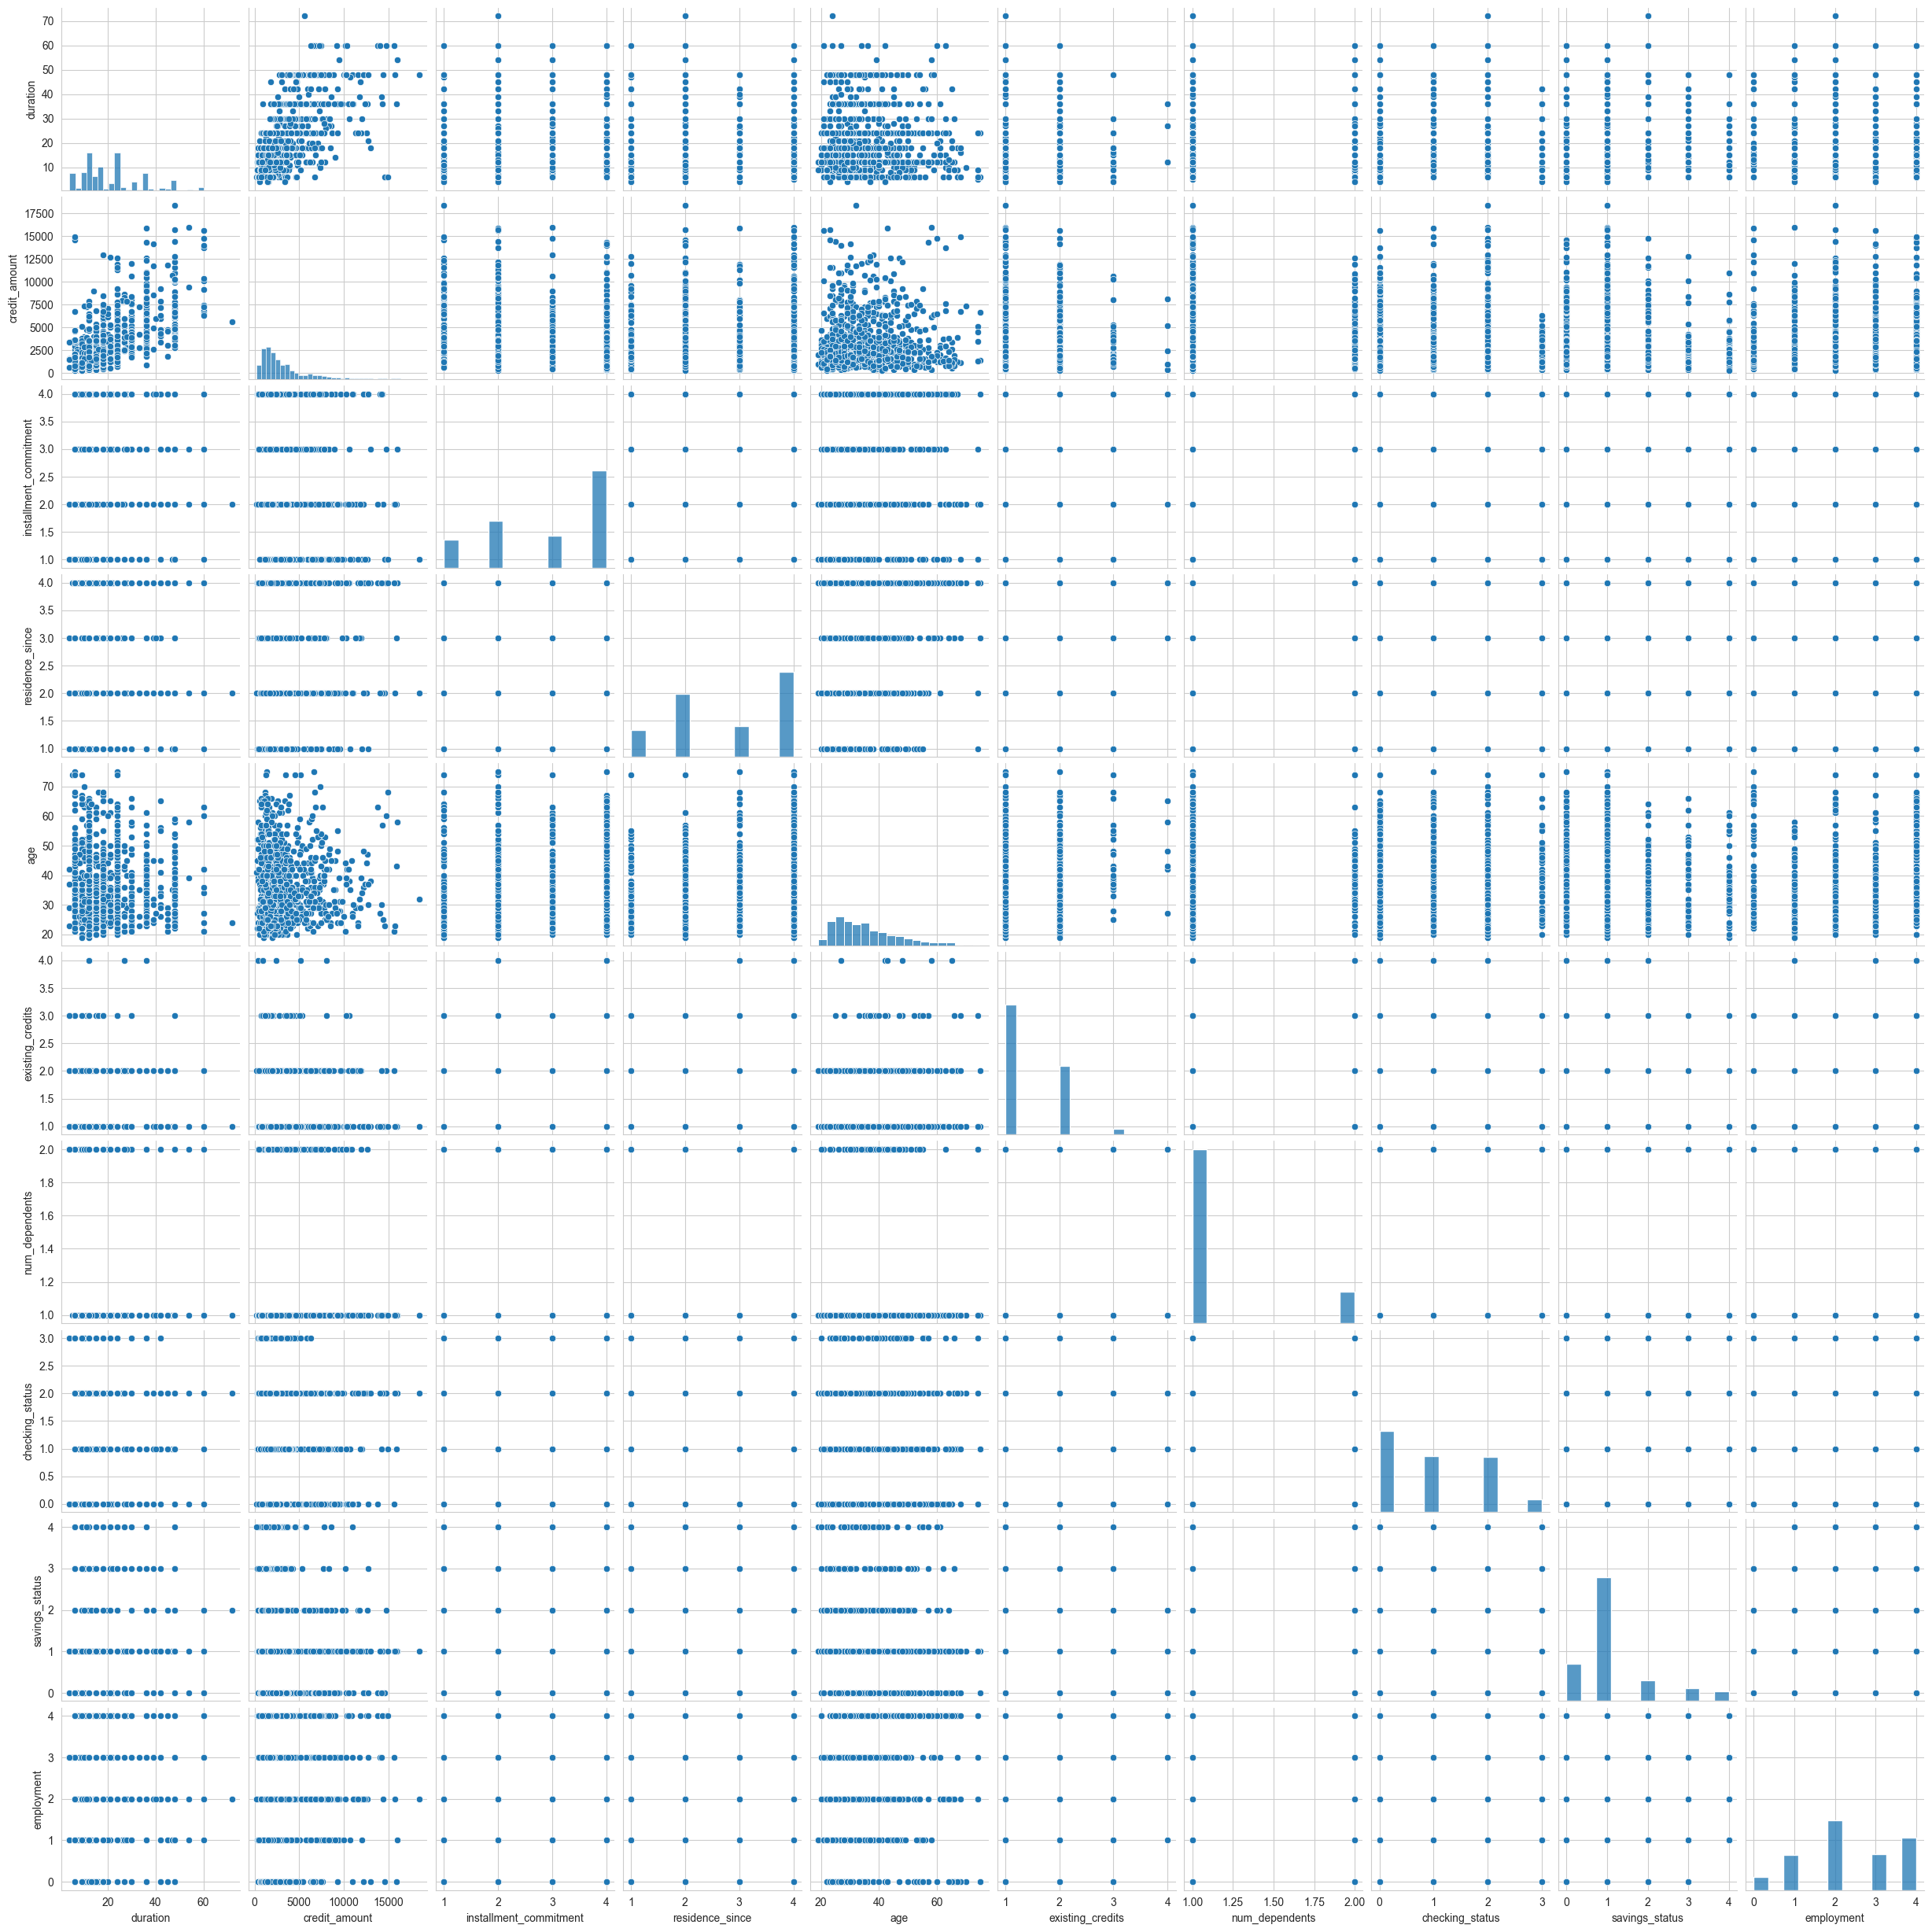

In [24]:
# Dataset con solo variables cuantitativas
df = X[quant_predictors].to_pandas()

# Pairplot con scatterplots
sns.pairplot(df, diag_kind="hist")  # diag_kind="kde" si prefieres densidades
plt.show()

In [25]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.02
Proportion of pair-wise correlations in [0.30, 0.60]:  0.0
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.98



## Experiment 1


In [26]:
run_experiment_1 = True

In [ ]:
if run_experiment_1: 
        
    n_realizations = 25
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = "20251001_204509"

    config_exp_1 = get_config_exp_1_german_credit()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

chunks:   0%|          | 0/5 [00:00<?, ?chunks/s]

random_state_chunk: [1715, 8771, 2856, 13344, 8734]
random_state: 1715
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 8771
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 2856
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1

chunks:  20%|██        | 1/5 [00:48<03:13, 48.43s/chunks]

len y_pred: 2
random_state_chunk: [3529, 1250, 12423, 17570, 18426]
random_state: 3529
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 1250
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 12423
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac

chunks:  40%|████      | 2/5 [01:37<02:25, 48.55s/chunks]

len y_pred: 2
random_state_chunk: [10885, 11167, 1700, 5231, 4425]
random_state: 10885
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 11167
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 1700
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac

chunks:  60%|██████    | 3/5 [02:51<02:00, 60.50s/chunks]

len y_pred: 2
random_state_chunk: [11049, 18381, 10937, 22992, 8033]
random_state: 11049
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 18381
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 10937
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
f

chunks:  80%|████████  | 4/5 [03:55<01:01, 61.82s/chunks]

len y_pred: 2
random_state_chunk: [5366, 54, 14295, 2870, 19582]
random_state: 5366
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 54
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 14295
frac_sample_size: 0.01
len y_pred: 2
frac_sample_size: 0.05
len y_pred: 2
frac_samp

chunks: 100%|██████████| 5/5 [05:00<00:00, 60.12s/chunks]

len y_pred: 2


In [28]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = "20251001_204509"    
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [29]:
# Open merged/joined results 

file_id = "20251001_204509"    
results_filename = f'results_exp_1_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [30]:
experiment_1_config = get_config_exp_1_german_credit()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [31]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

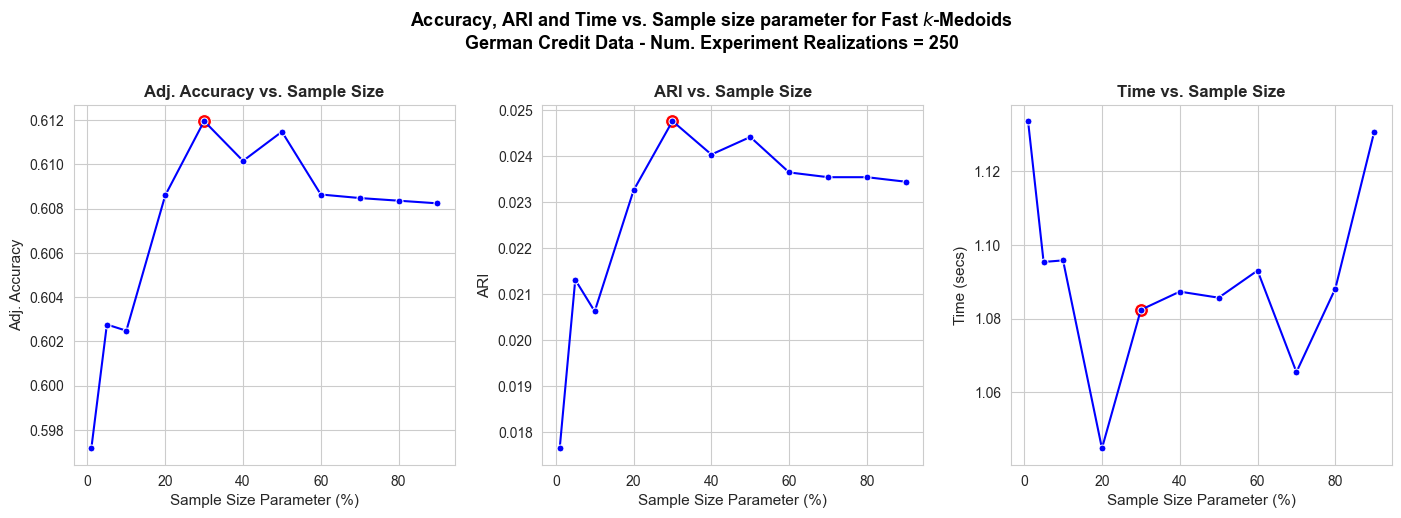

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nGerman Credit Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [33]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.01,1.133515,0.59716,0.017649
0.05,1.095337,0.60276,0.021316
0.10,1.095763,0.60248,0.020628
0.20,1.044824,0.60860,0.023261
0.30,1.082370,0.61196,0.024766
0.40,1.087299,0.61016,0.024040
0.50,1.085654,0.61148,0.024421
0.60,1.093010,0.60864,0.023650
0.70,1.065487,0.60848,0.023546


In [34]:
print(best_frac_sample_size)

0.3



## Experiment 3


In [39]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 25
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251002_183739'

    config_exp_3 = get_config_exp_3_german_credit()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 500 mins

chunks:   0%|          | 0/9 [00:00<?, ?chunks/s]

random_state_chunk: [1715, 8771, 2856]
random_state: 1715
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


random_state: 8771
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


random_state: 2856
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


frac_sample_size: 0.8


chunks:  11%|█         | 1/9 [06:53<55:09, 413.74s/chunks]

random_state_chunk: [13344, 8734, 3529]
random_state: 13344
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


random_state: 8734
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


random_state: 3529
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


frac_sample_size: 0.8


chunks:  22%|██▏       | 2/9 [13:51<48:31, 415.94s/chunks]

random_state_chunk: [1250, 12423, 17570]
random_state: 1250
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


random_state: 12423
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


random_state: 17570
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


frac_sample_size: 0.8


chunks:  33%|███▎      | 3/9 [24:30<51:46, 517.76s/chunks]

random_state_chunk: [18426, 10885, 11167]
random_state: 18426
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:38<00:00,  5.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:31<00:00,  4.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:58<00:00,  3.87s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [01:00<00:00,  4.04s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:57<00:00,  3.82s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:58<00:00,  3.93s/it]


random_state: 10885
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:29<00:00,  4.27s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.40s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:57<00:00,  5.70s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:13<00:00,  4.88s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [01:07<00:00,  4.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [01:03<00:00,  4.26s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [01:03<00:00,  4.23s/it]


random_state: 11167
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:28<00:00,  4.05s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:47<00:00,  6.75s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:35<00:00,  5.13s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:05<00:00,  4.36s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [01:01<00:00,  4.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


frac_sample_size: 0.8


chunks:  44%|████▍     | 4/9 [1:01:28<1:39:05, 1189.18s/chunks]

random_state_chunk: [1700, 5231, 4425]
random_state: 1700
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:23<00:00,  4.60s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:36<00:00,  5.18s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:01<00:00,  4.10s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [01:03<00:00,  4.20s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [01:10<00:00,  4.68s/it]


random_state: 5231
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


random_state: 4425
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


frac_sample_size: 0.8


chunks:  56%|█████▌    | 5/9 [1:22:31<1:21:02, 1215.58s/chunks]

random_state_chunk: [11049, 18381, 10937]
random_state: 11049
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:21<00:00,  3.13s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


random_state: 18381
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


random_state: 10937
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


frac_sample_size: 0.8


chunks:  67%|██████▋   | 6/9 [1:36:09<54:01, 1080.41s/chunks]  

random_state_chunk: [22992, 8033, 5366]
random_state: 22992
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


random_state: 8033
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


random_state: 5366
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


frac_sample_size: 0.8


chunks:  78%|███████▊  | 7/9 [1:45:38<30:26, 913.46s/chunks] 

random_state_chunk: [54, 14295, 2870]
random_state: 54
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


random_state: 14295
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


random_state: 2870
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


frac_sample_size: 0.8


chunks:  89%|████████▉ | 8/9 [1:56:24<13:48, 828.23s/chunks]

random_state_chunk: [19582]
random_state: 19582
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


frac_sample_size: 0.8


chunks: 100%|██████████| 9/9 [1:58:15<00:00, 788.43s/chunks]


In [47]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20251002_183739'
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'german_credit')
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [48]:
# Open merged/joined results 

file_id = '20251002_183739'
results_filename = f'results_exp_3_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [49]:
config_exp_3 = get_config_exp_3_german_credit()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

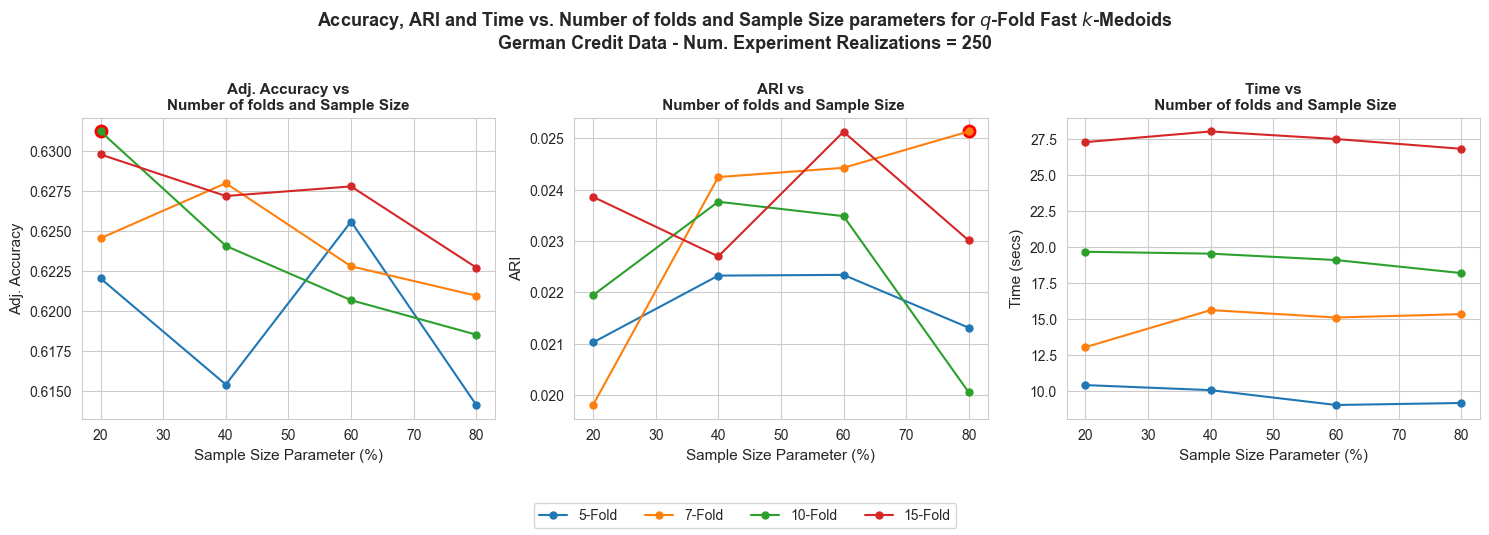

In [50]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nGerman Credit Data - Num. Experiment Realizations = 250", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [51]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.2,0.62204,0.021022,10.395544
1,5,0.4,0.61540,0.022323,10.045011
2,5,0.6,0.62560,0.022338,9.012889
3,5,0.8,0.61412,0.021308,9.151572
4,7,0.2,0.62456,0.019804,13.033620
5,7,0.4,0.62800,0.024243,15.610912
6,7,0.6,0.62280,0.024423,15.093582
7,7,0.8,0.62096,0.025131,15.329254
8,10,0.2,0.63124,0.021941,19.665156
9,10,0.4,0.62408,0.023762,19.532466


In [ ]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print('split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.5 
 best_n_splits 5.0 
 best_frac_sample_size 0.8



## Experiment 4

In [29]:
config_exp_4 = get_config_exp_4_german_credit()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis', 'euclidean', 'canberra', 'minkowski']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 25
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [30]:
run_experiment_4 = True

In [31]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = "20251001_204509"    

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas
   
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=accuracy_score #balanced_accuracy_score
                )

        # Save results
        results_filename = f'results_exp_4_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

chunks:   0%|          | 0/9 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [1715, 8771, 2856]
random_state: 1715
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


len y_pred: 2
random_state: 8771
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


len y_pred: 2
random_state: 2856
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  11%|█         | 1/9 [05:54<47:16, 354.51s/chunks]

len y_pred: 2
chunk_id 1
random_state_chunk: [13344, 8734, 3529]
random_state: 13344
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


len y_pred: 2
random_state: 8734
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


len y_pred: 2
random_state: 3529
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  22%|██▏       | 2/9 [09:04<30:03, 257.61s/chunks]

len y_pred: 2
chunk_id 2
random_state_chunk: [1250, 12423, 17570]
random_state: 1250
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


len y_pred: 2
random_state: 12423
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


len y_pred: 2
random_state: 17570
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  33%|███▎      | 3/9 [12:50<24:19, 243.29s/chunks]

len y_pred: 2
chunk_id 3
random_state_chunk: [18426, 10885, 11167]
random_state: 18426
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


len y_pred: 2
random_state: 10885
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


len y_pred: 2
random_state: 11167
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  44%|████▍     | 4/9 [16:27<19:24, 232.83s/chunks]

len y_pred: 2
chunk_id 4
random_state_chunk: [1700, 5231, 4425]
random_state: 1700
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


len y_pred: 2
random_state: 5231
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


len y_pred: 2
random_state: 4425
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  56%|█████▌    | 5/9 [19:42<14:37, 219.27s/chunks]

len y_pred: 2
chunk_id 5
random_state_chunk: [11049, 18381, 10937]
random_state: 11049
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


len y_pred: 2
random_state: 18381
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


len y_pred: 2
random_state: 10937
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  67%|██████▋   | 6/9 [23:01<10:37, 212.39s/chunks]

len y_pred: 2
chunk_id 6
random_state_chunk: [22992, 8033, 5366]
random_state: 22992
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


len y_pred: 2
random_state: 8033
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


len y_pred: 2
random_state: 5366
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  78%|███████▊  | 7/9 [26:52<07:16, 218.33s/chunks]

len y_pred: 2
chunk_id 7
random_state_chunk: [54, 14295, 2870]
random_state: 54
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


len y_pred: 2
random_state: 14295
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


len y_pred: 2
random_state: 2870
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  89%|████████▉ | 8/9 [30:26<03:37, 217.21s/chunks]

len y_pred: 2
chunk_id 8
random_state_chunk: [19582]
random_state: 19582
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks: 100%|██████████| 9/9 [31:31<00:00, 210.21s/chunks]

len y_pred: 2


In [32]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'german_credit')
    file_id = "20251001_204509"    
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [33]:
# Open merged/joined results 

results_filename = f'results_exp_4_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [34]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [35]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

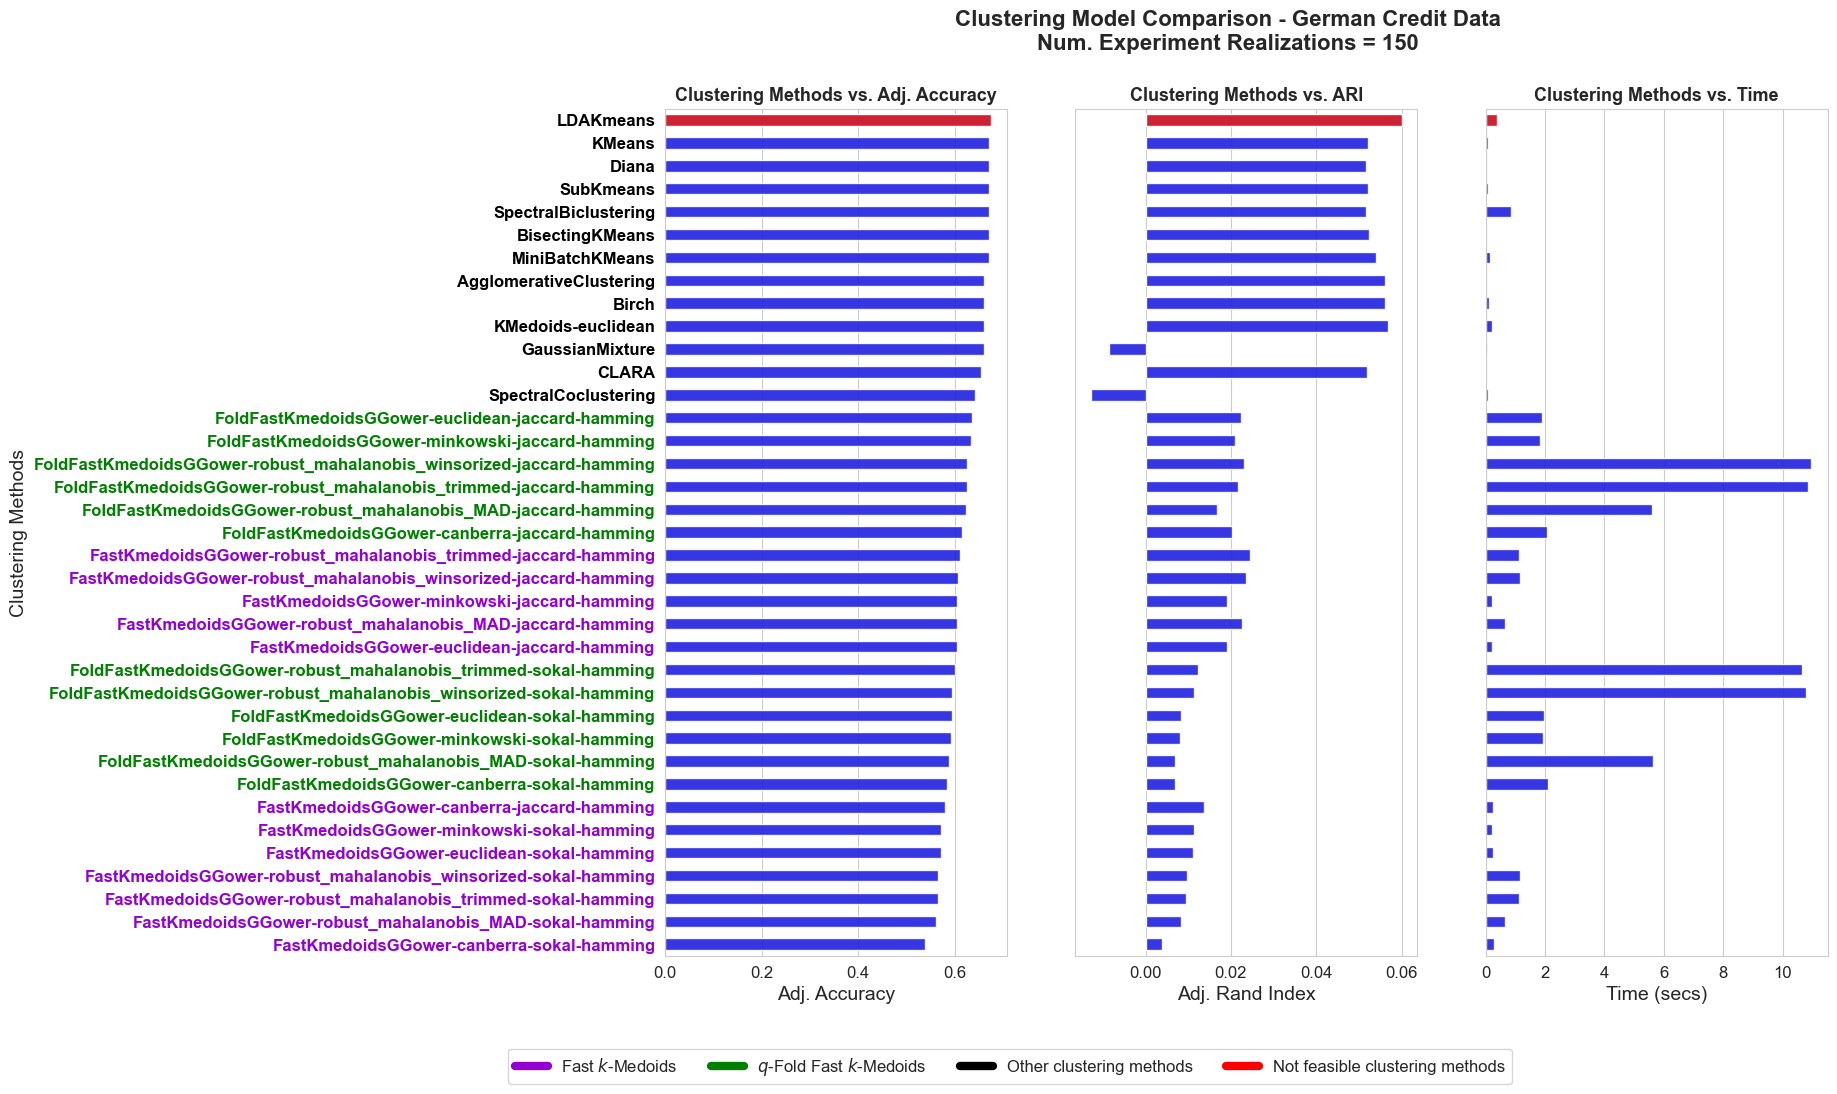

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - German Credit Data\nNum. Experiment Realizations = 150", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_german_credit_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [37]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [38]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
LDAKmeans,0.387980,0.67500,0.060049
KMeans,0.082554,0.67100,0.052010
Diana,0.020209,0.67100,0.051605
SubKmeans,0.062581,0.67100,0.052044
SpectralBiclustering,0.856688,0.67100,0.051605
BisectingKMeans,0.014299,0.67100,0.052416
MiniBatchKMeans,0.153774,0.67080,0.053986
AgglomerativeClustering,0.019973,0.66100,0.056115
Birch,0.099705,0.66100,0.056115


In [39]:
results.keys()

dict_keys([1715, 8771, 2856, 13344, 8734, 3529, 1250, 12423, 17570, 18426, 10885, 11167, 1700, 5231, 4425, 11049, 18381, 10937, 22992, 8033, 5366, 54, 14295, 2870, 19582])

In [40]:
random_state_mds = 1715

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.4, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [41]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


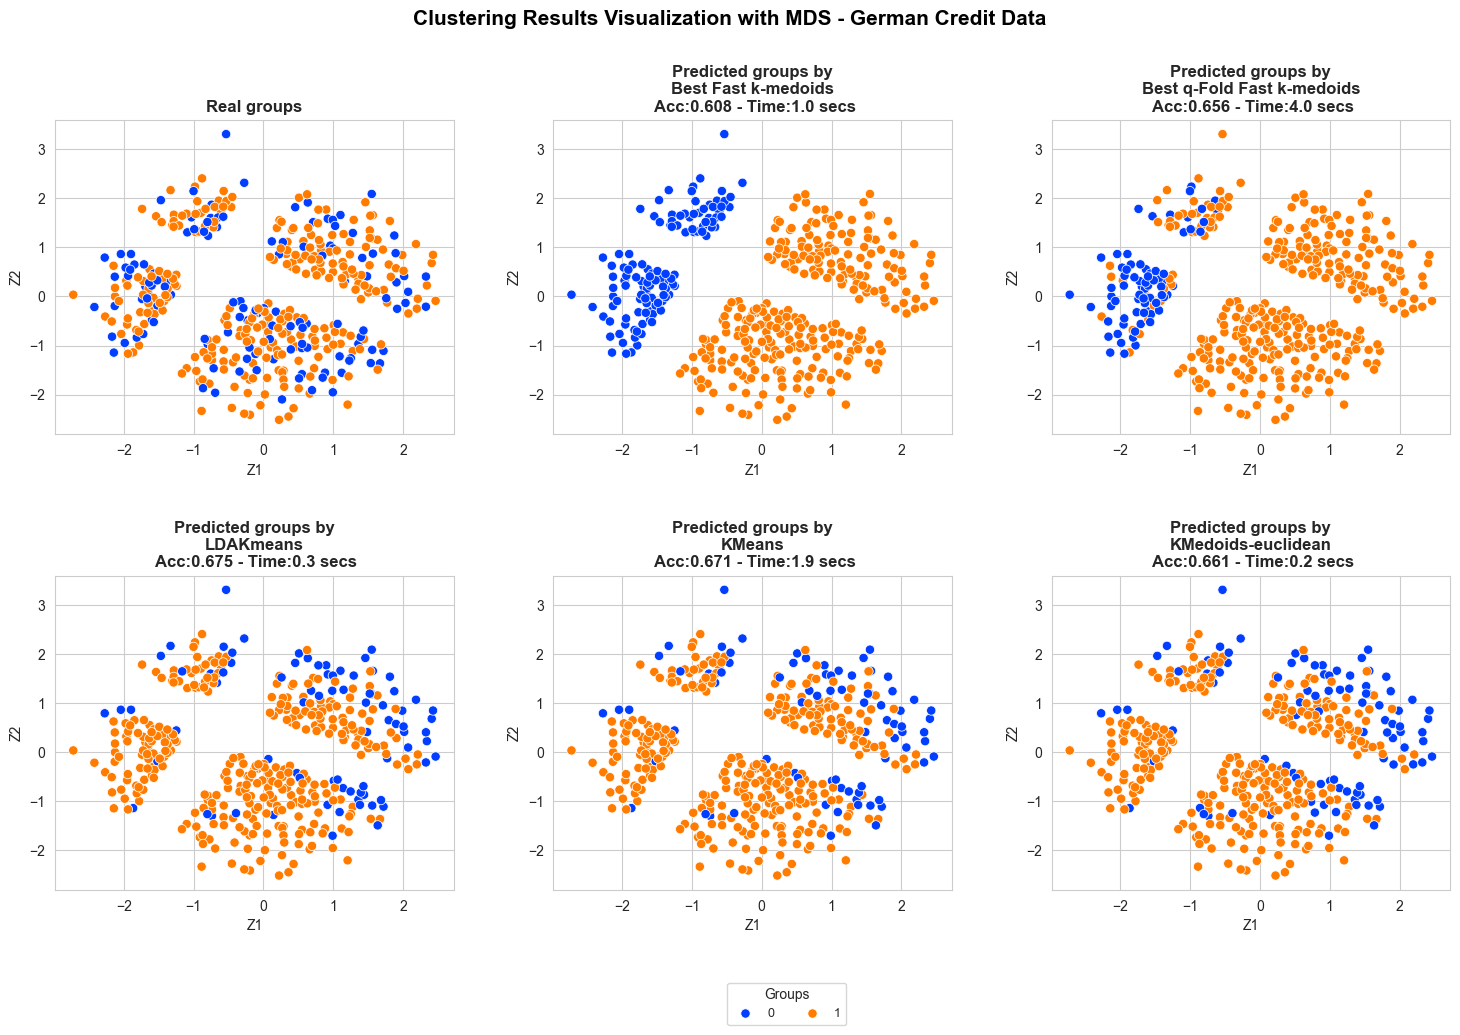

In [42]:
plot_filename = f'mds_plot_exp_4_german_credit_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'german_credit')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - German Credit Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)